# Conformal Prediction in Mathematical Programming

In many optimization problems, uncertainty enters through unknown or noisy
functions, constraints, or parameters. Common examples include:
- uncertain demand or returns,
- black-box process models,
- learned constraints or objectives.

Standard approaches either:
- ignore uncertainty, or
- rely on parametric assumptions that are difficult to justify.

Conformal prediction provides a principled alternative:
it constructs **distribution-free uncertainty sets** with finite-sample
coverage guarantees.

These sets can be embedded directly into optimization models,
enabling **robust and tractable decision making under data-driven uncertainty**.

This notebook illustrates how conformal prediction can be used to construct
optimization-ready uncertainty sets, following the spirit of
*Conformal Mixed-Integer Constraint Learning with Feasibility Guarantees (2025) by Ovalle, Biegler, Grossmann, Laird, Dulce-Rubio*.


We reuse the same heteroscedastic regression setting as in the *01_conformal_tutorial.ipynb* notebook.
The goal is to learn:
- a predictor $ \widehat{h}(x) $,
- an uncertainty envelope $ \widehat{C}_\alpha(x) $,

which will later be embedded into a mathematical program.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Input

# Load data
df = pd.read_csv("../data/heteroscedastic_data.csv")

X = df["x"].values
y = df["y"].values
n = len(X)

# Split indices
rng = np.random.default_rng(42)
idx = rng.permutation(n)

train_end = int(0.6 * n)
cal_end = int(0.8 * n)

train_idx = idx[:train_end]
cal_idx = idx[train_end:cal_end]
test_idx = idx[cal_end:]


2026-01-02 17:08:17.922844: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-02 17:08:17.936670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767391697.951968  654489 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767391697.956637  654489 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-02 17:08:17.973893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

We first train a regression model $ \widehat{h}(x) $.
The specific choice of model is immaterial: conformal prediction
will later provide uncertainty quantification in a model-agnostic way.


In [3]:
# Mean predictor
regr = Sequential()
regr.add(Input(shape=(1,)))
regr.add(Dense(30, activation="relu"))
regr.add(Dense(30, activation="relu"))
regr.add(Dense(30, activation="relu"))
regr.add(Dense(1))

regr.compile(optimizer="adam", loss="mean_squared_error")

regr.fit(
    X[train_idx],
    y[train_idx],
    epochs=1000,
    batch_size=64,
    verbose=0,
)

2026-01-02 17:08:19.984530: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


To obtain **input-dependent uncertainty sets**, we learn a residual scale model
$ \widehat{u}(x) $ from the training data.

This enables locally adaptive uncertainty sets, which are crucial for
efficient optimization.


In [4]:
# Training residuals
y_train_pred = regr.predict(X[train_idx].reshape(-1, 1), verbose=0).flatten()
train_residuals = np.abs(y[train_idx] - y_train_pred)

# Residual scale model
res_model = Sequential()
res_model.add(Input(shape=(1,)))
res_model.add(Dense(30, activation="relu"))
res_model.add(Dense(30, activation="relu"))
res_model.add(Dense(1))

res_model.compile(optimizer="adam", loss="mean_squared_error")

res_model.fit(
    X[train_idx],
    train_residuals,
    epochs=100,
    batch_size=32,
    verbose=0,
)


Using the calibration set, we compute normalized conformity scores

$$
s_i = \frac{|y_i - \widehat{h}(x_i)|}{\widehat{u}(x_i)},
$$

and select a conformal quantile to guarantee coverage.


In [5]:
alpha = 0.1

# Calibration predictions
y_cal_pred = regr.predict(X[cal_idx].reshape(-1, 1), verbose=0).flatten()
u_cal_pred = res_model.predict(X[cal_idx].reshape(-1, 1), verbose=0).flatten()

eps = 1e-8
u_cal_pred = np.maximum(u_cal_pred, eps)

# Normalized scores
s = np.abs(y[cal_idx] - y_cal_pred) / u_cal_pred

# Conformal quantile
n_cal = len(s)
q = np.quantile(
    s,
    np.ceil((n_cal + 1) * (1 - alpha)) / n_cal,
)

print(f"Conformal quantile: {q:.3f}")


Conformal quantile: 2.280


The resulting conformal prediction set is

$$
\widehat{C}_\alpha(x)
=
\left[
\widehat{h}(x) \pm \widehat{q}_{1-\alpha} \widehat{u}(x)
\right].
$$

Crucially, this set:
- is distribution-free,
- has finite-sample coverage,
- is explicitly parameterized by learned functions,
- can be embedded into optimization constraints.


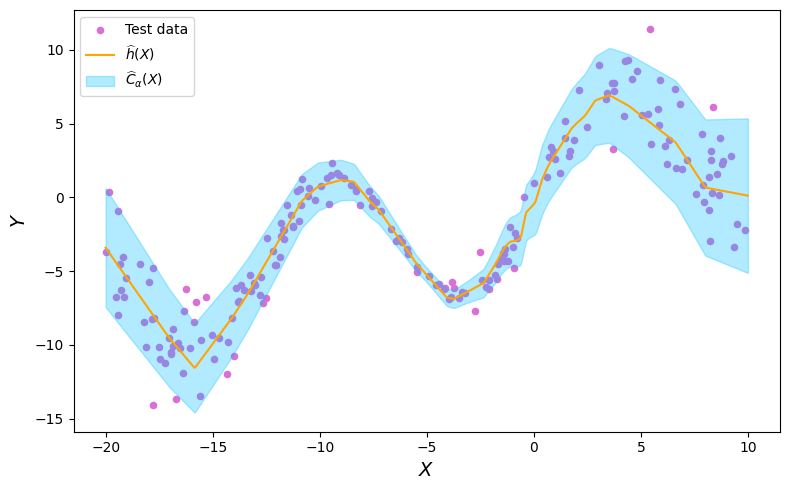

In [6]:
# Prediction grid
X_span = np.linspace(X.min(), X.max(), 500)
y_span = regr.predict(X_span.reshape(-1, 1), verbose=0).flatten()
u_span = res_model.predict(X_span.reshape(-1, 1), verbose=0).flatten()

lower_span = y_span - q * u_span
upper_span = y_span + q * u_span

plt.figure(figsize=(8, 5))

plt.scatter(
    X[test_idx],
    y[test_idx],
    color="orchid",
    label="Test data",
    s=20,
)

plt.plot(
    X_span,
    y_span,
    color="orange",
    label=r"$\widehat{h}(X)$",
)

plt.fill_between(
    X_span,
    lower_span,
    upper_span,
    color="deepskyblue",
    alpha=0.3,
    label=r"$\widehat{C}_\alpha(X)$",
)

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$Y$", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


At this point, we have constructed a **learned uncertainty set**
of the form

$$
Y \in \widehat{h}(x) \pm \widehat{q}_{1-\alpha} \widehat{u}(x).
$$

In the next section, we will show how sets of this form can be:
- embedded into linear constraints,
- used to produce decisions with formal probabilistic uncertainty quantification.

This is the key connection between conformal prediction
and optimization under uncertainty.

##  Motivation: Optimization Under Uncertainty

Many optimization problems involve unknown system responses that must satisfy hard safety or performance requirements.

Let  
- $ x $ denote a controllable decision variable (e.g., a setpoint, design variable, or operating condition),
- $y = h(x) $ denote an outcome of interest defined by an unknown mapping funtion $h$.

We are interested in solving problems of the form
$$
\min_{x \in \mathcal{X}} c(x),
$$
subject to **feasibility constraints**, such as
$$
h(x) \ge y_{\min},
\qquad
h0(x) \le y_{\max}.
$$

Such constraints arise naturally in safety-critical and reliability-driven applications.

## Learning a Predictive Model

We model the conditional response using a regression function
$$
\widehat{h}(x) \approx \mathbb{E}[Y(x) \mid x],
$$
together with a learned, input-dependent residual scale
$$
\widehat{u}(x) \approx |Y(x) - \widehat{h}(x)|.
$$

The pair $ (\widehat{h}, \widehat{u}) $ is trained using standard supervised learning techniques and calibrated via conformal prediction.


## Conformal Predictive Sets

Using a calibration dataset, we construct a conformal predictive set
$$
\widehat{\mathcal{C}}_\alpha(x)
=
\left[
\widehat{h}(x) - q_{1-\alpha}\,\widehat{u}(x),
\;
\widehat{h}(x) + q_{1-\alpha}\,\widehat{u}(x)
\right],
$$
where $ q_{1-\alpha} $ is a quantile of normalized calibration scores.

This set satisfies the **finite-sample coverage guarantee**
$$
\mathbb{P}\big( Y(x) \in \widehat{\mathcal{C}}_\alpha(x) \big) \ge 1 - \alpha,
$$
without any distributional assumptions.

## Optimization with Conformal Constraints

We now enforce safety by requiring **all realizations within the predictive set** to satisfy the constraints.

This leads to the optimization problem
$$
\begin{array}{ll}
\displaystyle \min_{x \in \mathcal{X}} & c(x) \\[0.5em]
\text{s.t.} 
& \inf_{y \in \widehat{\mathcal{C}}_\alpha(x)} y \;\ge\; y_{\min}, \\[0.25em]
& \sup_{y \in \widehat{\mathcal{C}}_\alpha(x)} y \;\le\; y_{\max}.
\end{array}
$$

Because $ \widehat{\mathcal{C}}_\alpha(x) $ is an interval, these constraints admit a deterministic reformulation:
$$
\widehat{h}(x) - q_{1-\alpha}\,\widehat{u}(x) \;\ge\; y_{\min},
$$
$$
\widehat{h}(x) + q_{1-\alpha}\,\widehat{u}(x) \;\le\; y_{\max}.
$$

--- 
## Pyomo and OMLT: Optimization with Learned Models

Before proceeding, we briefly introduce the tools used to embed learned models into optimization problems.

### Pyomo

**Pyomo** is an open-source Python-based modeling language for mathematical optimization.  
It allows users to formulate optimization problems using high-level, algebraic syntax that closely mirrors mathematical notation.

Key features of Pyomo include:
- Support for **linear, nonlinear, mixed-integer, and disjunctive** optimization models (amongst others).
- A solver-agnostic interface compatible with open-source and commercial solvers.
- Native support for constraints, objectives, and logical structure using Python code.

In this tutorial, Pyomo serves as the **host optimization framework** in which decision variables, objectives, and conformal safety constraints are defined.

### OMLT (Optimization and Machine Learning Toolkit)

**OMLT** is a library designed to integrate **trained machine learning models** into optimization formulations.

OMLT provides:
- Parsers for trained models (e.g., Keras, PyTorch via ONNX),
- Exact or approximate **algebraic reformulations** of neural networks,
- Multiple formulations for ReLU networks, including Big-M and complementarity-based approaches.

In this tutorial, OMLT is used to:
- Embed the neural networks \( \widehat{h}(x) \) and \( \widehat{u}(x) \) directly into a Pyomo model,
- Convert neural network evaluations into a set of deterministic constraints,
- Enable optimization **over the inputs of learned models** rather than treating them as black-box evaluators.

### Why This Matters

The combination of Pyomo and OMLT enables **end-to-end decision-making under uncertainty**, where:
- predictions are learned from data,
- uncertainty is quantified using conformal prediction,
- and decisions are computed by solving a mathematical program with provable guarantees.

## Embedding Conformal Prediction into Optimization with OMLT

We now show how to **embed conformal prediction sets directly into a mathematical programming formulation**.

The key idea is simple:

1. Train two neural networks:
   - $ \widehat{h}(x) $: mean prediction
   - $ \widehat{u}(x) $: residual scale
2. Use conformal calibration to compute a scalar quantile $ q_{1-\alpha} $.
3. Enforce safety by requiring **all values in the predictive set** to satisfy the constraint.


In [10]:
import pyomo.environ as pyo

from omlt import OmltBlock
from omlt.io.keras import keras_reader
from omlt.neuralnet import ReluBigMFormulation

# Input domain for the decision variable x
x_min, x_max = X.min(), X.max()
input_bounds = [(x_min, x_max)]

# Load Keras models into OMLT
net_h = keras_reader.load_keras_sequential(
    regr, None, input_bounds
)

net_u = keras_reader.load_keras_sequential(
    res_model, None, input_bounds
)

### Define the Optimization Model

We define:
- a decision variable $ x $,
- auxiliary variables for the network outputs $ \hat h(x) $ and $ \hat u(x) $.


In [12]:
model = pyo.ConcreteModel()

# Decision variable
model.x = pyo.Var(bounds=(x_min, x_max))

# Network outputs
model.h = pyo.Var()  
model.u = pyo.Var(within=pyo.NonNegativeReals)

# Embed mean regressor h(x)

model.nn_h = OmltBlock()

formulation_h = ReluBigMFormulation(net_h)
model.nn_h.build_formulation(formulation_h)

@model.Constraint()
def connect_h_input(m):
    return m.x == m.nn_h.inputs[0]

@model.Constraint()
def connect_h_output(m):
    return m.h == m.nn_h.outputs[0]

# Embed residual regressor u(x)

model.nn_u = OmltBlock()

formulation_u = ReluBigMFormulation(net_u)
model.nn_u.build_formulation(formulation_u)

@model.Constraint()
def connect_u_input(m):
    return m.x == m.nn_u.inputs[0]

@model.Constraint()
def connect_u_output(m):
    return m.u == m.nn_u.outputs[0]


###  Conformal Safety Constraints

Let $ q_{1-\alpha} $ be the conformal quantile obtained from calibration.

The predictive set is
$$
\widehat{\mathcal{C}}_\alpha(x)
=
\left[
\widehat{h}(x) - q_{1-\alpha}\widehat{u}(x),
\;
\widehat{h}(x) + q_{1-\alpha}\widehat{u}(x)
\right].
$$

Requiring all values in this set to be feasible yields two deterministic constraints.


In [16]:
# Conformal parameters
y_min = -5
y_max = 5

@model.Constraint()
def lower_conformal(m):
    return m.h - q * m.u >= y_min

@model.Constraint()
def upper_conformal(m):
    return m.h + q * m.u <= y_max


(type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
(type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


In [ ]:
model.obj = pyo.Objective(expr=model.x, sense=pyo.maximize)

# Solve
# The solver can be changed for any mixed-integer programming solver like "gurobi", "highs", "cplex", "glpk", etc.
solver = pyo.SolverFactory("cbc") 
results = solver.solve(model, tee=False)


'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


### Visualizing the Conformal Predictive Set and the Optimal Decision

We now visualize:
- the learned regression function $ \widehat{h}(x) $,
- the conformal predictive set $ \widehat{\mathcal{C}}_\alpha(x) $,
- the safety thresholds $ y_{\min}, y_{\max} $,
- and the optimal solution $ x^\star $ returned by the optimization model.

This figure provides a geometric interpretation of how the optimization problem selects a decision that is **robust with respect to the learned uncertainty set**.


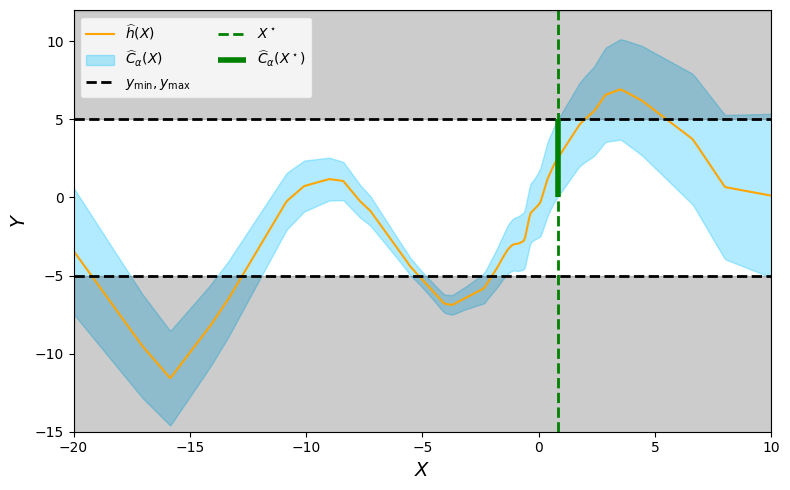

In [47]:
# Optimal solution from the optimization model
x_star = pyo.value(model.x)
h_star = pyo.value(model.h)
u_star = pyo.value(model.u)

# Prediction grid
X_span = np.linspace(X.min(), X.max(), 500)
y_span = regr.predict(X_span.reshape(-1, 1), verbose=0).flatten()
u_span = res_model.predict(X_span.reshape(-1, 1), verbose=0).flatten()

# Conformal predictive interval
lower_span = y_span - q * u_span
upper_span = y_span + q * u_span

plt.figure(figsize=(8, 5))


# Mean prediction
plt.plot(
    X_span,
    y_span,
    color="orange",
    label=r"$\widehat{h}(X)$",
)

# Conformal predictive set
plt.fill_between(
    X_span,
    lower_span,
    upper_span,
    color="deepskyblue",
    alpha=0.3,
    label=r"$\widehat{C}_\alpha(X)$",
)

# Unsafe regions (background shading)
plt.fill_between(
    X_span,
    y_span.min() - 5,
    y_min,
    color="black",
    alpha=0.2,
)

plt.fill_between(
    X_span,
    y_max,
    y_span.max() + 5,
    color="black",
    alpha=0.2,
)


# Safety thresholds
plt.axhline(
    y_min,
    color="black",
    linestyle="--",
    lw=2,
    label=r"$y_{\min}, y_{\max}$",
)

plt.axhline(
    y_max,
    color="black",
    linestyle="--",
    lw=2,
)

plt.axvline(
    x_star,
    color="green",
    lw=2,
    linestyle="--",
    label=r"$X^\star$"
)

# Predictive interval at x*
plt.vlines(
    x_star,
    h_star - q * u_star,
    h_star + q * u_star,
    color="green",
    lw=4,
    label=r"$\widehat{C}_\alpha(X^\star)$",
)

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$Y$", fontsize=14)
plt.xlim(-20, 10)
plt.ylim(-15, 12)
plt.legend(loc="upper left", ncol=2)
plt.tight_layout()
plt.show()


### Interpretation

The vertical line at $ x^\star $ corresponds to the **largest admissible value of the decision variable** that remains feasible under uncertainty.

In particular, $ x^\star $ is chosen such that the *entire conformal predictive interval*
$$
\widehat{\mathcal{C}}_\alpha(x^\star)
=
\left[
\widehat{h}(x^\star) - q_{1-\alpha}\widehat{u}(x^\star),
\;
\widehat{h}(x^\star) + q_{1-\alpha}\widehat{u}(x^\star)
\right]
$$
lies within the safe region $ [y_{\min}, y_{\max}] $.

Any larger value of $ x $ would cause part of the predictive set to cross a safety boundary, violating feasibility with respect to the learned uncertainty.  

Thus, the optimization problem selects the **maximum operating point that respects the safety bounds once uncertainty is taken into account**, rather than optimizing only for the mean prediction.
